In [3]:
import pandas as pd
import numpy as np
import os
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler

PARQUET_PATH = '/kaggle/input/windowed-calf/WindowedCalf.parquet'

if os.path.exists(PARQUET_PATH):
    df = pd.read_parquet(PARQUET_PATH)
    print(f"Arquivo carregado com sucesso: {PARQUET_PATH}")
    print(f"Dimensoes do Dataset: {df.shape[0]} janelas e {df.shape[1]} colunas.")
else:
    print(f"ERRO: Arquivo nao encontrado em {PARQUET_PATH}. Verifique o caminho.")

Arquivo carregado com sucesso: /kaggle/input/windowed-calf/WindowedCalf.parquet
Dimensoes do Dataset: 60768 janelas e 81 colunas.


In [2]:
print("--- Informacoes do DataFrame ---")
df.info()

if not df.empty:
    sample_acc_x = df.iloc[0]['acc_x']
    print("\n--- Verificacao de Tamanho da Janela ---")
    print(f"Tamanho do array acc_x: {len(sample_acc_x)} (Esperado: 75)")
    print(f"Tipo do dado dentro do array: {type(sample_acc_x)}")

print("\n--- Contagem de Amostras por Comportamento ---")
class_counts = df['label'].value_counts()
print(class_counts)

standard_cols = ['dateTime', 'calf_id', 'segId', 'acc_x', 'acc_y', 'acc_z', 'label']
feature_cols = [c for c in df.columns if c not in standard_cols]

print(f"\n--- Features Extraidas ({len(feature_cols)} no total) ---")
if len(feature_cols) > 0:
    print("Primeiras 10 features:", feature_cols[:10])
else:
    print("Nenhuma feature extra encontrada (apenas dados brutos).")

print("\n--- Primeiras 3 linhas do Dataset ---")
pd.set_option('display.max_columns', 10)
print(df.head(3))

--- Informacoes do DataFrame ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60768 entries, 0 to 60767
Data columns (total 81 columns):
 #   Column                                    Non-Null Count  Dtype         
---  ------                                    --------------  -----         
 0   dateTime                                  60768 non-null  datetime64[ns]
 1   calf_id                                   60768 non-null  object        
 2   acc_x                                     60768 non-null  object        
 3   acc_y                                     60768 non-null  object        
 4   acc_z                                     60768 non-null  object        
 5   label                                     60768 non-null  object        
 6   accY_Entropy                              60768 non-null  float64       
 7   accX_Signal distance                      60768 non-null  float64       
 8   accY_Sum absolute diff                    60768 non-null  float64       


In [7]:
BATCH_SIZE = 64
NUM_WORKERS = 2

# ==============================================================================
# DATASET
# ==============================================================================
class CalfHybridDataset(Dataset):
    def __init__(self, signals, features, labels):
        """
        signals: Array Numpy (N, 3, 75)
        features: Array Numpy (N, 75)
        labels: Array Numpy (N,)
        """
        self.signals = torch.FloatTensor(signals)
        self.features = torch.FloatTensor(features)
        self.labels = torch.LongTensor(labels)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        # Retorna uma tupla: (Sinal Temporal, Features Estáticas, Label)
        return self.signals[idx], self.features[idx], self.labels[idx]

# ==============================================================================
# PIPELINE DE PREPARAÇÃO DE DADOS
# ==============================================================================
def prepare_dataloaders(parquet_path):
    print("1. Carregando Dataset...")
    df = pd.read_parquet(parquet_path)
    
    class_counts = df['label'].value_counts()
    to_remove = class_counts[class_counts < 2].index
    if len(to_remove) > 0:
        print(f"   Removendo classes com amostras insuficientes (<2): {list(to_remove)}")
        original_len = len(df)
        df = df[~df['label'].isin(to_remove)].reset_index(drop=True)
        print(f"   Linhas removidas: {original_len - len(df)} | Novo total: {len(df)}")
    
    standard_cols = ['dateTime', 'calfId', 'calf_id', 'segId', 'acc_x', 'acc_y', 'acc_z', 'label']
    feature_cols = [c for c in df.columns if c not in standard_cols]
    
    print(f"   Total de Amostras: {len(df)}")
    print(f"   Features TSFEL encontradas: {len(feature_cols)}")

    print("2. Processando Sinais Temporais (Acc X, Y, Z)...")
    x_stack = np.stack(df['acc_x'].values)
    y_stack = np.stack(df['acc_y'].values)
    z_stack = np.stack(df['acc_z'].values)
    
    signals = np.stack([x_stack, y_stack, z_stack], axis=1).astype(np.float32)
    print("3. Processando Features Estatísticas...")
    features = df[feature_cols].values.astype(np.float32)
    features = np.nan_to_num(features)

    print("4. Codificando Labels...")
    le = LabelEncoder()
    labels = le.fit_transform(df['label'])
    class_names = le.classes_
    print(f"   Classes ({len(class_names)}): {class_names}")

    # Divisão (Split 80/10/10)
    indices = np.arange(len(df))
    train_idx, temp_idx, y_train, y_temp = train_test_split(
        indices, labels, test_size=0.2, stratify=labels, random_state=42
    )
    val_idx, test_idx, y_val, y_test = train_test_split(
        temp_idx, y_temp, test_size=0.5, stratify=y_temp, random_state=42
    )
    print(f"   Split: Treino={len(train_idx)}, Val={len(val_idx)}, Teste={len(test_idx)}")
    
    print("5. Normalizando Dados...")
    train_signals = signals[train_idx]
    mean_signal = np.mean(train_signals, axis=(0, 2), keepdims=True) 
    std_signal = np.std(train_signals, axis=(0, 2), keepdims=True)  
    signals_norm = (signals - mean_signal) / (std_signal + 1e-6)
    
    # Normalização das Features TSFEL 
    scaler_feats = StandardScaler()
    scaler_feats.fit(features[train_idx])
    features_norm = scaler_feats.transform(features)

    print("6. Criando Datasets e Dataloaders...")
    train_ds = CalfHybridDataset(signals_norm[train_idx], features_norm[train_idx], labels[train_idx])
    val_ds   = CalfHybridDataset(signals_norm[val_idx],   features_norm[val_idx],   labels[val_idx])
    test_ds  = CalfHybridDataset(signals_norm[test_idx],  features_norm[test_idx],  labels[test_idx])
    
    train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
    val_dl   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)
    test_dl  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)
    
    return train_dl, val_dl, test_dl, class_names, len(feature_cols)

In [8]:
dl_train, dl_val, dl_test, classes, n_feats = prepare_dataloaders(PARQUET_PATH)

print("\n--- Teste de Integridade do DataLoader ---")
acc_batch, feat_batch, label_batch = next(iter(dl_train))

print(f"Batch Shapes:")
print(f"   Sinais (Input CNN):    {acc_batch.shape}  (Batch, Canais, Tempo)")
print(f"   Features (Input MLP):  {feat_batch.shape} (Batch, N_Features)")
print(f"   Labels:                {label_batch.shape}")

print(f"\nExemplo de Label: {label_batch[0]} -> {classes[label_batch[0]]}")

# Check de Normalização (Média deve ser proxima de 0 e Std proxima de 1)
print(f"\nStats do Batch de Sinais (Normalizado):")
print(f"   Média: {acc_batch.mean():.4f}, Std: {acc_batch.std():.4f}")

1. Carregando Dataset...
   Removendo classes com amostras insuficientes (<2): ['other']
   Linhas removidas: 1 | Novo total: 60767
   Total de Amostras: 60767
   Features TSFEL encontradas: 75
2. Processando Sinais Temporais (Acc X, Y, Z)...
3. Processando Features Estatísticas...
4. Codificando Labels...
   Classes (18): ['abnormal' 'drinking' 'eating' 'elimination' 'grooming' 'lying'
 'lying_down_action' 'oral_manipulation' 'play' 'rare_event' 'rising'
 'rumination' 'running' 'sniff' 'social_interaction' 'srs' 'standing'
 'walking']
   Split: Treino=48613, Val=6077, Teste=6077
5. Normalizando Dados...
6. Criando Datasets e Dataloaders...

--- Teste de Integridade do DataLoader ---
Batch Shapes:
   Sinais (Input CNN):    torch.Size([64, 3, 75])  (Batch, Canais, Tempo)
   Features (Input MLP):  torch.Size([64, 75]) (Batch, N_Features)
   Labels:                torch.Size([64])

Exemplo de Label: 5 -> lying

Stats do Batch de Sinais (Normalizado):
   Média: 0.0392, Std: 0.9107


In [10]:
import torch.nn as nn
import torch.nn.functional as F

class HybridCNNLSTM(nn.Module):
    def __init__(self, num_classes, n_features_tsfel, hidden_lstm=64):
        super(HybridCNNLSTM, self).__init__()
        
        # ==========================================
        # RAMO 1: SINAIS TEMPORAIS (CNN + LSTM)
        # Entrada: (Batch, 3, 75)
        # ==========================================
        # Bloco CNN (Feature Extractor)
        self.cnn = nn.Sequential(
            nn.Conv1d(in_channels=3, out_channels=64, kernel_size=5, padding=2),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.3),
            
            nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2) # Reduz dimensão temporal (75 -> 37)
        )
        
        # Bloco LSTM (Sequence Learner)
        # A entrada será (Batch, Time, Features) após a CNN
        self.lstm = nn.LSTM(
            input_size=128,    # Canais vindos da CNN
            hidden_size=hidden_lstm, 
            num_layers=2,      # Empilhar LSTMs ajuda em padrões complexos
            batch_first=True, 
            bidirectional=True, # Bidirecional é ótimo para classificação (vê passado e futuro da janela)
            dropout=0.3
        )
        
        # ==========================================
        # RAMO 2: FEATURES TSFEL (MLP)
        # Entrada: (Batch, 75)
        # ==========================================
        self.mlp_tsfel = nn.Sequential(
            nn.Linear(n_features_tsfel, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.4)
        )
        
        # ==========================================
        # FUSÃO E CLASSIFICAÇÃO
        # ==========================================
        self.classifier = nn.Sequential(
            nn.Linear((hidden_lstm * 2) + 64, 128),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(128, num_classes)
        )

    def forward(self, x_signal, x_features):
        # --- CAMINHO 1: CNN+LSTM --- (Batch, 3, 75)
        x_cnn = self.cnn(x_signal)      # Sai: (Batch, 128, 37)
        
        # Prepara para LSTM: PyTorch quer (Batch, Time, Features)
        x_cnn = x_cnn.permute(0, 2, 1)  # Sai: (Batch, 37, 128)
        lstm_out, _ = self.lstm(x_cnn)  # Sai: (Batch, 37, hidden*2)
        
        # Pega apenas o último passo temporal (o "resumo" da sequência)
        x_temporal = lstm_out[:, -1, :] # Sai: (Batch, hidden*2)
        
        # --- CAMINHO 2: TSFEL ---
        # x_features: (Batch, 75)
        x_static = self.mlp_tsfel(x_features) # Sai: (Batch, 64)
        
        # --- FUSÃO ---
        combined = torch.cat((x_temporal, x_static), dim=1)
        
        # --- CLASSIFICAÇÃO ---
        logits = self.classifier(combined)
        
        return logits

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Simula dados
BATCH_TEST = 32
N_CLASSES = 18 # `other` fraco. Só 1 janela
N_FEATS = 75

model = HybridCNNLSTM(num_classes=N_CLASSES, n_features_tsfel=N_FEATS).to(device)

dummy_signal = torch.randn(BATCH_TEST, 3, 75).to(device)
dummy_feats = torch.randn(BATCH_TEST, N_FEATS).to(device)

output = model(dummy_signal, dummy_feats)
print(f"Modelo Criado com Sucesso!")
print(f"Input Signal: {dummy_signal.shape}")
print(f"Input Features: {dummy_feats.shape}")
print(f"Output Logits: {output.shape} (Esperado: {BATCH_TEST}, {N_CLASSES})")

Modelo Criado com Sucesso!
Input Signal: torch.Size([32, 3, 75])
Input Features: torch.Size([32, 75])
Output Logits: torch.Size([32, 18]) (Esperado: 32, 18)


In [16]:
import torch.optim as optim
from tqdm import tqdm
import copy

def train_model(model, train_loader, val_loader, device, num_epochs=100):
    criterion = nn.CrossEntropyLoss()
    # AdamW costuma ser melhor que Adam puro para generalização
    optimizer = optim.AdamW(model.parameters(), lr=0.01, weight_decay=1e-4)
    
    # Scheduler: Reduz LR se validação estagnar
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=5, factor=0.1, verbose=True)
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    history = {'train_loss': [], 'val_loss': [], 'val_acc': []}

    for epoch in range(num_epochs):
        if (epoch+1) % 5 == 0:
            print(f'\nEpoch {epoch+1}/{num_epochs}')
            print('-' * 10)

        # --- TREINO ---
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        for signals, features, labels in tqdm(train_loader, desc="Treinando"):
            signals = signals.to(device)
            features = features.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            # Forward com DUAS entradas
            outputs = model(signals, features)
            loss = criterion(outputs, labels)

            loss.backward()
            
            # Gradient Clipping (Importante para LSTMs não explodirem)
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            
            optimizer.step()

            # Estatísticas
            running_loss += loss.item() * signals.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = correct / total
        if (epoch+1) % 5 == 0: 
            print(f'Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

        # --- VALIDAÇÃO ---
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        
        with torch.no_grad():
            for signals, features, labels in val_loader:
                signals = signals.to(device)
                features = features.to(device)
                labels = labels.to(device)

                outputs = model(signals, features)
                loss = criterion(outputs, labels)

                val_loss += loss.item() * signals.size(0)
                _, predicted = torch.max(outputs, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        val_loss = val_loss / len(val_loader.dataset)
        val_acc = val_correct / val_total
        if (epoch+1) % 5 == 0:
            print(f'Val Loss: {val_loss:.4f} Acc: {val_acc:.4f}')
        
        # Scheduler Step
        scheduler.step(val_loss)

        # Salva Melhor Modelo
        if val_acc > best_acc:
            best_acc = val_acc
            best_model_wts = copy.deepcopy(model.state_dict())
            torch.save(model.state_dict(), "best_hybrid_model.pth")
            print("💾 Melhor modelo salvo!")
            
        history['train_loss'].append(epoch_loss)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)

    print(f'Melhor Val Acc: {best_acc:4f}')
    return model, history

# Instancia
model = HybridCNNLSTM(num_classes=len(classes), n_features_tsfel=n_feats).to(device)

# Treina
trained_model, hist = train_model(model, dl_train, dl_val, device)

Treinando: 100%|██████████| 760/760 [00:06<00:00, 123.03it/s]


💾 Melhor modelo salvo!


Treinando: 100%|██████████| 760/760 [00:06<00:00, 121.46it/s]


💾 Melhor modelo salvo!

Epoch 5/500
----------


Treinando: 100%|██████████| 760/760 [00:06<00:00, 126.37it/s]

Train Loss: 1.0278 Acc: 0.6704


Val Loss: 0.9113 Acc: 0.7013
💾 Melhor modelo salvo!


Treinando: 100%|██████████| 760/760 [00:05<00:00, 128.62it/s]


💾 Melhor modelo salvo!


Treinando: 100%|██████████| 760/760 [00:05<00:00, 129.86it/s]


💾 Melhor modelo salvo!


Treinando: 100%|██████████| 760/760 [00:05<00:00, 133.09it/s]


💾 Melhor modelo salvo!

Epoch 10/500
----------


Treinando: 100%|██████████| 760/760 [00:05<00:00, 133.43it/s]

Train Loss: 0.9966 Acc: 0.6819


Val Loss: 0.8751 Acc: 0.7171
💾 Melhor modelo salvo!


Treinando: 100%|██████████| 760/760 [00:05<00:00, 130.02it/s]



Epoch 15/500
----------


Treinando: 100%|██████████| 760/760 [00:05<00:00, 132.23it/s]

Train Loss: 0.9867 Acc: 0.6817


Val Loss: 0.8706 Acc: 0.7124


Treinando: 100%|██████████| 760/760 [00:05<00:00, 131.02it/s]


💾 Melhor modelo salvo!


Treinando: 100%|██████████| 760/760 [00:05<00:00, 128.16it/s]



Epoch 20/500
----------


Treinando: 100%|██████████| 760/760 [00:05<00:00, 131.59it/s]

Train Loss: 0.9782 Acc: 0.6857


Val Loss: 0.8622 Acc: 0.7120


Treinando: 100%|██████████| 760/760 [00:05<00:00, 126.75it/s]



Epoch 25/500
----------


Treinando: 100%|██████████| 760/760 [00:05<00:00, 129.17it/s]

Train Loss: 0.9678 Acc: 0.6881


Val Loss: 0.8506 Acc: 0.7235


Treinando: 100%|██████████| 760/760 [00:05<00:00, 131.32it/s]



Epoch 30/500
----------


Treinando: 100%|██████████| 760/760 [00:05<00:00, 128.10it/s]

Train Loss: 0.9641 Acc: 0.6932


Val Loss: 0.8701 Acc: 0.7073


Treinando: 100%|██████████| 760/760 [00:06<00:00, 126.14it/s]


💾 Melhor modelo salvo!


Treinando: 100%|██████████| 760/760 [00:05<00:00, 132.12it/s]


💾 Melhor modelo salvo!

Epoch 35/500
----------


Treinando: 100%|██████████| 760/760 [00:05<00:00, 132.05it/s]

Train Loss: 0.9583 Acc: 0.6926


Val Loss: 0.8395 Acc: 0.7273


Treinando: 100%|██████████| 760/760 [00:05<00:00, 130.40it/s]



Epoch 40/500
----------


Treinando: 100%|██████████| 760/760 [00:05<00:00, 130.75it/s]

Train Loss: 0.9587 Acc: 0.6928


Val Loss: 0.8186 Acc: 0.7226


Treinando: 100%|██████████| 760/760 [00:06<00:00, 121.60it/s]



Epoch 45/500
----------


Treinando: 100%|██████████| 760/760 [00:05<00:00, 126.83it/s]

Train Loss: 0.9547 Acc: 0.6940


Val Loss: 0.8249 Acc: 0.7226


Treinando: 100%|██████████| 760/760 [00:05<00:00, 131.90it/s]


💾 Melhor modelo salvo!


Treinando: 100%|██████████| 760/760 [00:05<00:00, 133.49it/s]


💾 Melhor modelo salvo!


Treinando: 100%|██████████| 760/760 [00:06<00:00, 126.58it/s]


💾 Melhor modelo salvo!

Epoch 50/500
----------


Treinando: 100%|██████████| 760/760 [00:06<00:00, 123.08it/s]

Train Loss: 0.8834 Acc: 0.7121


Val Loss: 0.7864 Acc: 0.7425


Treinando: 100%|██████████| 760/760 [00:05<00:00, 127.22it/s]



Epoch 55/500
----------


Treinando: 100%|██████████| 760/760 [00:05<00:00, 132.35it/s]

Train Loss: 0.8658 Acc: 0.7179


Val Loss: 0.7722 Acc: 0.7423


Treinando: 100%|██████████| 760/760 [00:06<00:00, 125.39it/s]



Epoch 60/500
----------


Treinando: 100%|██████████| 760/760 [00:06<00:00, 125.46it/s]

Train Loss: 0.8616 Acc: 0.7187


Val Loss: 0.7647 Acc: 0.7481
💾 Melhor modelo salvo!


Treinando: 100%|██████████| 760/760 [00:05<00:00, 133.03it/s]



Epoch 65/500
----------


Treinando: 100%|██████████| 760/760 [00:05<00:00, 130.80it/s]

Train Loss: 0.8545 Acc: 0.7233


Val Loss: 0.7688 Acc: 0.7435


Treinando: 100%|██████████| 760/760 [00:06<00:00, 124.00it/s]


💾 Melhor modelo salvo!


Treinando: 100%|██████████| 760/760 [00:05<00:00, 133.07it/s]



Epoch 70/500
----------


Treinando: 100%|██████████| 760/760 [00:05<00:00, 133.08it/s]

Train Loss: 0.8501 Acc: 0.7254


Val Loss: 0.7575 Acc: 0.7477


Treinando: 100%|██████████| 760/760 [00:05<00:00, 128.18it/s]



Epoch 75/500
----------


Treinando: 100%|██████████| 760/760 [00:05<00:00, 133.79it/s]

Train Loss: 0.8407 Acc: 0.7235


Val Loss: 0.7552 Acc: 0.7484


Treinando: 100%|██████████| 760/760 [00:05<00:00, 129.65it/s]


💾 Melhor modelo salvo!


Treinando: 100%|██████████| 760/760 [00:05<00:00, 128.87it/s]



Epoch 80/500
----------


Treinando: 100%|██████████| 760/760 [00:06<00:00, 122.26it/s]

Train Loss: 0.8367 Acc: 0.7258


Val Loss: 0.7524 Acc: 0.7472


Treinando: 100%|██████████| 760/760 [00:05<00:00, 131.85it/s]


💾 Melhor modelo salvo!

Epoch 85/500
----------


Treinando: 100%|██████████| 760/760 [00:05<00:00, 132.48it/s]

Train Loss: 0.8449 Acc: 0.7242


Val Loss: 0.7538 Acc: 0.7481


Treinando: 100%|██████████| 760/760 [00:06<00:00, 124.58it/s]


💾 Melhor modelo salvo!


Treinando: 100%|██████████| 760/760 [00:06<00:00, 126.30it/s]


💾 Melhor modelo salvo!


Treinando: 100%|██████████| 760/760 [00:05<00:00, 131.31it/s]


💾 Melhor modelo salvo!

Epoch 90/500
----------


Treinando: 100%|██████████| 760/760 [00:05<00:00, 131.63it/s]

Train Loss: 0.8408 Acc: 0.7256


Val Loss: 0.7507 Acc: 0.7499


Treinando: 100%|██████████| 760/760 [00:05<00:00, 132.78it/s]


💾 Melhor modelo salvo!


Treinando: 100%|██████████| 760/760 [00:05<00:00, 128.83it/s]



Epoch 95/500
----------


Treinando: 100%|██████████| 760/760 [00:06<00:00, 124.41it/s]


Train Loss: 0.8404 Acc: 0.7248
Val Loss: 0.7537 Acc: 0.7477


Treinando: 100%|██████████| 760/760 [00:05<00:00, 131.23it/s]



Epoch 100/500
----------


Treinando: 100%|██████████| 760/760 [00:05<00:00, 128.14it/s]

Train Loss: 0.8336 Acc: 0.7240


Val Loss: 0.7516 Acc: 0.7474


Treinando: 100%|██████████| 760/760 [00:05<00:00, 130.64it/s]



Epoch 105/500
----------


Treinando: 100%|██████████| 760/760 [00:05<00:00, 130.54it/s]

Train Loss: 0.8398 Acc: 0.7257


Val Loss: 0.7546 Acc: 0.7476


Treinando: 100%|██████████| 760/760 [00:05<00:00, 129.83it/s]



Epoch 110/500
----------


Treinando: 100%|██████████| 760/760 [00:05<00:00, 130.53it/s]

Train Loss: 0.8415 Acc: 0.7260


Val Loss: 0.7510 Acc: 0.7494


Treinando: 100%|██████████| 760/760 [00:05<00:00, 133.26it/s]



Epoch 115/500
----------


Treinando: 100%|██████████| 760/760 [00:05<00:00, 133.57it/s]

Train Loss: 0.8412 Acc: 0.7227


Val Loss: 0.7506 Acc: 0.7472


Treinando: 100%|██████████| 760/760 [00:05<00:00, 130.86it/s]



Epoch 120/500
----------


Treinando: 100%|██████████| 760/760 [00:05<00:00, 133.08it/s]

Train Loss: 0.8400 Acc: 0.7257


Val Loss: 0.7501 Acc: 0.7474


Treinando: 100%|██████████| 760/760 [00:05<00:00, 131.10it/s]



Epoch 125/500
----------


Treinando: 100%|██████████| 760/760 [00:05<00:00, 129.24it/s]

Train Loss: 0.8424 Acc: 0.7243


Val Loss: 0.7522 Acc: 0.7491


Treinando: 100%|██████████| 760/760 [00:06<00:00, 126.30it/s]



Epoch 130/500
----------


Treinando: 100%|██████████| 760/760 [00:05<00:00, 129.53it/s]

Train Loss: 0.8380 Acc: 0.7253


Val Loss: 0.7527 Acc: 0.7469


Treinando: 100%|██████████| 760/760 [00:05<00:00, 131.15it/s]



Epoch 135/500
----------


Treinando: 100%|██████████| 760/760 [00:05<00:00, 132.16it/s]

Train Loss: 0.8388 Acc: 0.7249


Val Loss: 0.7518 Acc: 0.7479


Treinando: 100%|██████████| 760/760 [00:06<00:00, 122.76it/s]



Epoch 140/500
----------


Treinando: 100%|██████████| 760/760 [00:06<00:00, 125.82it/s]

Train Loss: 0.8395 Acc: 0.7257


Val Loss: 0.7539 Acc: 0.7463


Treinando: 100%|██████████| 760/760 [00:05<00:00, 131.43it/s]



Epoch 145/500
----------


Treinando: 100%|██████████| 760/760 [00:05<00:00, 134.17it/s]

Train Loss: 0.8403 Acc: 0.7251


Val Loss: 0.7531 Acc: 0.7510


Treinando: 100%|██████████| 760/760 [00:05<00:00, 129.28it/s]



Epoch 150/500
----------


Treinando: 100%|██████████| 760/760 [00:05<00:00, 128.21it/s]

Train Loss: 0.8420 Acc: 0.7253


Val Loss: 0.7517 Acc: 0.7481


Treinando: 100%|██████████| 760/760 [00:05<00:00, 131.22it/s]



Epoch 155/500
----------


Treinando: 100%|██████████| 760/760 [00:05<00:00, 131.55it/s]

Train Loss: 0.8383 Acc: 0.7246


Val Loss: 0.7518 Acc: 0.7500


Treinando: 100%|██████████| 760/760 [00:05<00:00, 129.34it/s]



Epoch 160/500
----------


Treinando: 100%|██████████| 760/760 [00:05<00:00, 132.37it/s]

Train Loss: 0.8376 Acc: 0.7244


Val Loss: 0.7519 Acc: 0.7504


Treinando: 100%|██████████| 760/760 [00:05<00:00, 130.08it/s]



Epoch 165/500
----------


Treinando: 100%|██████████| 760/760 [00:05<00:00, 133.78it/s]

Train Loss: 0.8355 Acc: 0.7267


Val Loss: 0.7498 Acc: 0.7484


Treinando: 100%|██████████| 760/760 [00:05<00:00, 130.74it/s]



Epoch 170/500
----------


Treinando: 100%|██████████| 760/760 [00:05<00:00, 130.40it/s]

Train Loss: 0.8414 Acc: 0.7239


Val Loss: 0.7532 Acc: 0.7474


Treinando: 100%|██████████| 760/760 [00:05<00:00, 131.43it/s]



Epoch 175/500
----------


Treinando: 100%|██████████| 760/760 [00:05<00:00, 131.71it/s]

Train Loss: 0.8391 Acc: 0.7247


Val Loss: 0.7544 Acc: 0.7512


Treinando: 100%|██████████| 760/760 [00:05<00:00, 131.25it/s]



Epoch 180/500
----------


Treinando: 100%|██████████| 760/760 [00:05<00:00, 130.14it/s]

Train Loss: 0.8416 Acc: 0.7253


Val Loss: 0.7524 Acc: 0.7487


Treinando: 100%|██████████| 760/760 [00:05<00:00, 130.02it/s]



Epoch 185/500
----------


Treinando: 100%|██████████| 760/760 [00:05<00:00, 131.42it/s]

Train Loss: 0.8369 Acc: 0.7245


Val Loss: 0.7528 Acc: 0.7495


Treinando: 100%|██████████| 760/760 [00:05<00:00, 127.68it/s]



Epoch 190/500
----------


Treinando: 100%|██████████| 760/760 [00:06<00:00, 122.69it/s]

Train Loss: 0.8367 Acc: 0.7254


Val Loss: 0.7513 Acc: 0.7484


Treinando: 100%|██████████| 760/760 [00:05<00:00, 133.76it/s]



Epoch 195/500
----------


Treinando: 100%|██████████| 760/760 [00:05<00:00, 131.81it/s]

Train Loss: 0.8392 Acc: 0.7247


Val Loss: 0.7507 Acc: 0.7484


Treinando: 100%|██████████| 760/760 [00:06<00:00, 122.82it/s]



Epoch 200/500
----------


Treinando: 100%|██████████| 760/760 [00:06<00:00, 125.58it/s]

Train Loss: 0.8361 Acc: 0.7243


Val Loss: 0.7544 Acc: 0.7499


Treinando: 100%|██████████| 760/760 [00:05<00:00, 135.26it/s]



Epoch 205/500
----------


Treinando: 100%|██████████| 760/760 [00:05<00:00, 131.78it/s]

Train Loss: 0.8396 Acc: 0.7257


Val Loss: 0.7506 Acc: 0.7499


Treinando: 100%|██████████| 760/760 [00:05<00:00, 133.31it/s]



Epoch 210/500
----------


Treinando: 100%|██████████| 760/760 [00:05<00:00, 135.32it/s]

Train Loss: 0.8369 Acc: 0.7240


Val Loss: 0.7537 Acc: 0.7479


Treinando: 100%|██████████| 760/760 [00:05<00:00, 128.06it/s]



Epoch 215/500
----------


Treinando: 100%|██████████| 760/760 [00:05<00:00, 131.46it/s]

Train Loss: 0.8395 Acc: 0.7248


Val Loss: 0.7525 Acc: 0.7492


Treinando: 100%|██████████| 760/760 [00:05<00:00, 131.75it/s]



Epoch 220/500
----------


Treinando: 100%|██████████| 760/760 [00:05<00:00, 132.70it/s]

Train Loss: 0.8355 Acc: 0.7256


Val Loss: 0.7529 Acc: 0.7494


Treinando: 100%|██████████| 760/760 [00:05<00:00, 130.39it/s]



Epoch 225/500
----------


Treinando: 100%|██████████| 760/760 [00:05<00:00, 128.88it/s]

Train Loss: 0.8435 Acc: 0.7222


Val Loss: 0.7504 Acc: 0.7469


Treinando: 100%|██████████| 760/760 [00:05<00:00, 131.05it/s]



Epoch 230/500
----------


Treinando: 100%|██████████| 760/760 [00:05<00:00, 132.62it/s]

Train Loss: 0.8354 Acc: 0.7258


Val Loss: 0.7516 Acc: 0.7491


Treinando: 100%|██████████| 760/760 [00:05<00:00, 130.44it/s]



Epoch 235/500
----------


Treinando: 100%|██████████| 760/760 [00:05<00:00, 131.88it/s]

Train Loss: 0.8387 Acc: 0.7250


Val Loss: 0.7502 Acc: 0.7477


Treinando: 100%|██████████| 760/760 [00:05<00:00, 131.45it/s]



Epoch 240/500
----------


Treinando: 100%|██████████| 760/760 [00:05<00:00, 129.87it/s]

Train Loss: 0.8367 Acc: 0.7259


Val Loss: 0.7527 Acc: 0.7464


Treinando: 100%|██████████| 760/760 [00:06<00:00, 122.89it/s]



Epoch 245/500
----------


Treinando: 100%|██████████| 760/760 [00:05<00:00, 128.22it/s]

Train Loss: 0.8399 Acc: 0.7240


Val Loss: 0.7536 Acc: 0.7489


Treinando: 100%|██████████| 760/760 [00:05<00:00, 127.96it/s]



Epoch 250/500
----------


Treinando: 100%|██████████| 760/760 [00:05<00:00, 128.56it/s]

Train Loss: 0.8372 Acc: 0.7254


Val Loss: 0.7498 Acc: 0.7466


Treinando: 100%|██████████| 760/760 [00:05<00:00, 127.23it/s]



Epoch 255/500
----------


Treinando: 100%|██████████| 760/760 [00:05<00:00, 127.76it/s]

Train Loss: 0.8366 Acc: 0.7250


Val Loss: 0.7509 Acc: 0.7504


Treinando: 100%|██████████| 760/760 [00:05<00:00, 130.71it/s]



Epoch 260/500
----------


Treinando: 100%|██████████| 760/760 [00:05<00:00, 132.81it/s]

Train Loss: 0.8369 Acc: 0.7255


Val Loss: 0.7511 Acc: 0.7482


Treinando: 100%|██████████| 760/760 [00:05<00:00, 128.75it/s]



Epoch 265/500
----------


Treinando: 100%|██████████| 760/760 [00:05<00:00, 130.25it/s]

Train Loss: 0.8370 Acc: 0.7250


Val Loss: 0.7510 Acc: 0.7461


Treinando: 100%|██████████| 760/760 [00:05<00:00, 130.52it/s]



Epoch 270/500
----------


Treinando: 100%|██████████| 760/760 [00:05<00:00, 131.82it/s]

Train Loss: 0.8357 Acc: 0.7250


Val Loss: 0.7524 Acc: 0.7487


Treinando: 100%|██████████| 760/760 [00:05<00:00, 127.05it/s]



Epoch 275/500
----------


Treinando: 100%|██████████| 760/760 [00:05<00:00, 130.46it/s]

Train Loss: 0.8374 Acc: 0.7241


Val Loss: 0.7516 Acc: 0.7472


Treinando:  99%|█████████▉| 755/760 [00:05<00:00, 131.58it/s]


KeyboardInterrupt: 

In [22]:
import torch
import torch.nn as nn

class RobustHybridModel(nn.Module):
    def __init__(self, num_classes, n_features_tsfel, hidden_lstm=128):
        super(RobustHybridModel, self).__init__()
        
        # ============================================================
        # RAMO 1: SINAIS (CNN Clássica + LSTM Padrão)
        # Entrada: (Batch, 3, 75)
        # ============================================================
        
        # 1. Feature Extractor (CNN)
        # Usamos Sequential simples. Sem classes aninhadas complexas.
        self.cnn = nn.Sequential(
            # Bloco 1: (3 -> 64)
            nn.Conv1d(in_channels=3, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2), # Reduz tamanho temporal pela metade (75 -> 37)
            
            # Bloco 2: (64 -> 128)
            nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2), # Reduz tamanho temporal (37 -> 18)
            
            # Bloco 3: (128 -> 256)
            nn.Conv1d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm1d(256),
            nn.ReLU()
            # Saída aqui será (Batch, 256, 18)
        )
        
        # 2. Sequence Learner (LSTM)
        # Recebe 256 features da CNN
        self.lstm = nn.LSTM(
            input_size=256,
            hidden_size=hidden_lstm,
            num_layers=1,        # 1 Camada é mais estável para começar
            batch_first=True,    # PyTorch padrão é (Batch, Time, Feats)
            bidirectional=True   # Olha passado e futuro
        )
        # Saída da LSTM Bidirecional tem tamanho: hidden_lstm * 2
        
        # ============================================================
        # RAMO 2: FEATURES TSFEL (MLP Simples)
        # Entrada: (Batch, 75)
        # ============================================================
        self.mlp_tsfel = nn.Sequential(
            nn.Linear(n_features_tsfel, 128),
            nn.BatchNorm1d(128), # Normalização ajuda muito a não estourar a loss
            nn.ReLU(),
            nn.Dropout(0.5)      # Dropout alto para regularizar
        )
        
        # ============================================================
        # FUSÃO E CLASSIFICAÇÃO
        # ============================================================
        # LSTM (hidden*2) + TSFEL (128)
        fusion_dim = (hidden_lstm * 2) + 128
        
        self.classifier = nn.Sequential(
            nn.Linear(fusion_dim, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, num_classes)
        )
        
        # Inicialização de Pesos (CRUCIAL para evitar Loss inicial de 7.0)
        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            nn.init.kaiming_normal_(m.weight)
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.Conv1d):
            nn.init.kaiming_normal_(m.weight)
        elif isinstance(m, nn.BatchNorm1d):
            nn.init.constant_(m.weight, 1)
            nn.init.constant_(m.bias, 0)

    def forward(self, x_signal, x_features):
        # --- FLUXO SINAL ---
        # 1. CNN
        # x_signal: (Batch, 3, 75)
        features_cnn = self.cnn(x_signal) # Sai: (Batch, 256, 18)
        
        # 2. Preparar para LSTM
        # Permuta de (Batch, Canais, Tempo) -> (Batch, Tempo, Canais)
        features_cnn = features_cnn.permute(0, 2, 1) # Sai: (Batch, 18, 256)
        
        # 3. LSTM
        # output: (Batch, Time, Hidden*2)
        # h_n: (Num_Layers*2, Batch, Hidden)
        lstm_out, (h_n, c_n) = self.lstm(features_cnn)
        
        # Pegamos a concatenação do último estado oculto forward e backward
        # h_n[-2] é o forward final, h_n[-1] é o backward final
        temporal_embedding = torch.cat((h_n[-2], h_n[-1]), dim=1) # (Batch, Hidden*2)
        
        # --- FLUXO TSFEL ---
        static_embedding = self.mlp_tsfel(x_features) # (Batch, 128)
        
        # --- FUSÃO ---
        combined = torch.cat((temporal_embedding, static_embedding), dim=1)
        
        # --- CLASSIFICAÇÃO ---
        logits = self.classifier(combined)
        
        return logits

In [27]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import copy
import os
from sklearn.utils.class_weight import compute_class_weight

def train_robust_model_advanced(train_dl, val_dl, num_classes, n_feats, device, epochs=50, checkpoint_path="best_hybrid_model.pth"):
    print(f"🚀 Iniciando Treino Avançado (CNN+LSTM+TSFEL) no device: {device}")
    
    # 1. Instancia o Modelo
    model = RobustHybridModel(num_classes, n_feats).to(device)
    
    # ==============================================================================
    # 1.5. CHECKPOINT LOADING (WARM START)
    # ==============================================================================
    if os.path.exists(checkpoint_path):
        print(f"🔄 Checkpoint encontrado: '{checkpoint_path}'")
        try:
            # Carrega os pesos (map_location garante que carregue na CPU/GPU correta)
            state_dict = torch.load(checkpoint_path, map_location=device)
            model.load_state_dict(state_dict)
            print("✅ Pesos carregados com sucesso! O treino continuará de onde parou (Warm Start).")
        except Exception as e:
            print(f"⚠️ Erro ao carregar o arquivo (pode estar corrompido ou ser arquitetura diferente): {e}")
            print("   -> Iniciando treino do ZERO (pesos aleatórios).")
    else:
        print("✨ Nenhum checkpoint encontrado. Iniciando treino do ZERO.")

    # 2. Cálculo Automático de Pesos das Classes (Para Balanceamento)
    print("⚖️ Calculando pesos das classes para a Loss Function...")
    try:
        # Tenta pegar labels como numpy array
        all_labels = train_dl.dataset.labels.cpu().numpy()
        classes_unique = np.unique(all_labels)
        
        # 'balanced' calcula o inverso da frequência
        class_weights = compute_class_weight(class_weight='balanced', classes=classes_unique, y=all_labels)
        class_weights_tensor = torch.FloatTensor(class_weights).to(device)
        print(f"   Pesos calculados! (Ex: Classe 0 peso {class_weights[0]:.2f})")
    except Exception as e:
        print(f"   ⚠️ Aviso: Não foi possível calcular pesos automáticos ({e}). Usando pesos iguais.")
        class_weights_tensor = None

    # 3. Configuração de Otimização
    # Nota: Ao carregar um modelo, o AdamW vai "resetar" o momentum. 
    # Isso é bom para Fine-Tuning, pois dá um novo impulso na otimização.
    optimizer = optim.AdamW(model.parameters(), lr=0.0001, weight_decay=1e-3)
    
    criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)
    
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', patience=5, factor=0.5, verbose=True
    )

    # 4. Variáveis de Controle
    # Inicializa o 'melhor modelo' com o estado atual (seja ele carregado ou novo)
    best_model_wts = copy.deepcopy(model.state_dict())
    
    # Para definir a best_acc inicial, fazemos uma validação rápida se carregamos pesos
    # Se não, começa com 0
    best_acc = 0.0
    
    early_stopping_patience = 10
    early_stopping_counter = 0

    # --- LOOP DE ÉPOCAS ---
    for epoch in range(epochs):
        model.train() # Modo Treino
        
        train_loss = 0.0
        correct = 0
        total = 0
        
        for batch_idx, (x_sig, x_feat, y) in enumerate(train_dl):
            x_sig, x_feat, y = x_sig.to(device), x_feat.to(device), y.to(device)
            
            if torch.isnan(x_sig).any() or torch.isnan(x_feat).any():
                print(f"❌ ERRO: NaNs no input (Batch {batch_idx}). Abortando.")
                return model
            
            optimizer.zero_grad()
            outputs = model(x_sig, x_feat)
            loss = criterion(outputs, y)
            
            if torch.isnan(loss):
                print("❌ ERRO: Loss virou NaN. Otimização explodiu.")
                return model

            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            
            train_loss += loss.item() * x_sig.size(0)
            _, pred = outputs.max(1)
            correct += pred.eq(y).sum().item()
            total += y.size(0)

        # Médias de Treino
        avg_train_loss = train_loss / len(train_dl.dataset)
        train_acc = 100. * correct / total

        # --- VALIDAÇÃO ---
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        
        with torch.no_grad():
            for x_sig, x_feat, y in val_dl:
                x_sig, x_feat, y = x_sig.to(device), x_feat.to(device), y.to(device)
                
                outputs = model(x_sig, x_feat)
                loss = criterion(outputs, y)
                
                val_loss += loss.item() * x_sig.size(0)
                _, pred = outputs.max(1)
                val_correct += pred.eq(y).sum().item()
                val_total += y.size(0)
        
        avg_val_loss = val_loss / len(val_dl.dataset)
        val_acc = 100. * val_correct / val_total
        
        # --- LOGS ---
        print(f"Ep {epoch+1:02d}/{epochs} | "
              f"Train Loss: {avg_train_loss:.4f} Acc: {train_acc:.2f}% | "
              f"Val Loss: {avg_val_loss:.4f} Acc: {val_acc:.2f}%")
        
        scheduler.step(avg_val_loss)

        # --- CHECKPOINT & EARLY STOPPING ---
        if val_acc > best_acc:
            best_acc = val_acc
            best_model_wts = copy.deepcopy(model.state_dict())
            torch.save(model.state_dict(), checkpoint_path)
            print(f"   💾 Novo Recorde! Modelo salvo em '{checkpoint_path}'. (Acc: {best_acc:.2f}%)")
            early_stopping_counter = 0 
        else:
            early_stopping_counter += 1
            
        if early_stopping_counter >= early_stopping_patience:
            print(f"\n🛑 Early Stopping ativado! Sem melhoria por {early_stopping_patience} épocas.")
            break

    print(f"\n🏁 Treino Finalizado. Melhor Acurácia de Validação: {best_acc:.2f}%")
    
    # Carrega os pesos do melhor modelo antes de retornar
    model.load_state_dict(best_model_wts)
    return model

# --- EXECUÇÃO ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

trained_model = train_robust_model_advanced(
    dl_train, dl_val, 
    num_classes=len(classes), 
    n_feats=n_feats, 
    device=device, 
    epochs=50
)

🚀 Iniciando Treino Avançado (CNN+LSTM+TSFEL) no device: cuda
🔄 Checkpoint encontrado: 'best_hybrid_model.pth'
✅ Pesos carregados com sucesso! O treino continuará de onde parou (Warm Start).
⚖️ Calculando pesos das classes para a Loss Function...
   Pesos calculados! (Ex: Classe 0 peso 7.14)


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Ep 01/50 | Train Loss: 0.5197 Acc: 77.72% | Val Loss: 2.1069 Acc: 75.07%
   💾 Novo Recorde! Modelo salvo em 'best_hybrid_model.pth'. (Acc: 75.07%)
Ep 02/50 | Train Loss: 0.4777 Acc: 78.65% | Val Loss: 2.1485 Acc: 75.91%
   💾 Novo Recorde! Modelo salvo em 'best_hybrid_model.pth'. (Acc: 75.91%)
Ep 03/50 | Train Loss: 0.4633 Acc: 79.31% | Val Loss: 2.2692 Acc: 75.81%
Ep 04/50 | Train Loss: 0.4540 Acc: 79.56% | Val Loss: 2.2756 Acc: 75.81%
Ep 05/50 | Train Loss: 0.4466 Acc: 79.88% | Val Loss: 2.3717 Acc: 75.37%
Ep 06/50 | Train Loss: 0.4558 Acc: 79.82% | Val Loss: 2.3678 Acc: 76.21%
   💾 Novo Recorde! Modelo salvo em 'best_hybrid_model.pth'. (Acc: 76.21%)
Ep 07/50 | Train Loss: 0.4359 Acc: 79.98% | Val Loss: 2.3654 Acc: 75.79%
Ep 08/50 | Train Loss: 0.4272 Acc: 80.09% | Val Loss: 2.3631 Acc: 75.66%
Ep 09/50 | Train Loss: 0.4167 Acc: 80.46% | Val Loss: 2.3372 Acc: 76.49%
   💾 Novo Recorde! Modelo salvo em 'best_hybrid_model.pth'. (Acc: 76.49%)
Ep 10/50 | Train Loss: 0.4194 Acc: 80.64% | Val

In [31]:
def train_finetune_stage2(train_dl, val_dl, num_classes, n_feats, device, epochs=20, checkpoint_path="best_hybrid_model.pth"):
    print(f"\nFINE-TUNING (Sem Pesos, LR Baixo)")
    
    # Instancia o Modelo
    model = RobustHybridModel(num_classes, n_feats).to(device)
    
    # Carrega o Modelo Treinado no Estágio 1
    if os.path.exists(checkpoint_path):
        print(f"🔄 Carregando pesos do Estágio 1: '{checkpoint_path}'")
        state_dict = torch.load(checkpoint_path, map_location=device)
        model.load_state_dict(state_dict)
    else:
        return None

    optimizer = optim.AdamW(model.parameters(), lr=0.0001, weight_decay=1e-4)
    print("Loss Function: Padrão (Sem pesos de classe) -> Foco em Acurácia Global")
    criterion = nn.CrossEntropyLoss(weight=None)
    
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', patience=3, factor=0.5, verbose=True
    )

    finetune_path = "best_hybrid_finetuned.pth"
    best_acc = 0.0 
    
    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        correct = 0
        total = 0
        
        for x_sig, x_feat, y in train_dl:
            x_sig, x_feat, y = x_sig.to(device), x_feat.to(device), y.to(device)
            
            optimizer.zero_grad()
            outputs = model(x_sig, x_feat)
            loss = criterion(outputs, y)
            
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            
            train_loss += loss.item() * x_sig.size(0)
            _, pred = outputs.max(1)
            correct += pred.eq(y).sum().item()
            total += y.size(0)

        avg_train_loss = train_loss / len(train_dl.dataset)
        train_acc = 100. * correct / total

        # Validação
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        with torch.no_grad():
            for x_sig, x_feat, y in val_dl:
                x_sig, x_feat, y = x_sig.to(device), x_feat.to(device), y.to(device)
                outputs = model(x_sig, x_feat)
                loss = criterion(outputs, y)
                val_loss += loss.item() * x_sig.size(0)
                _, pred = outputs.max(1)
                val_correct += pred.eq(y).sum().item()
                val_total += y.size(0)
        
        avg_val_loss = val_loss / len(val_dl.dataset)
        val_acc = 100. * val_correct / val_total
        
        print(f"Fine-Tune Ep {epoch+1:02d} | Train Loss: {avg_train_loss:.4f} Acc: {train_acc:.2f}% | Val Loss: {avg_val_loss:.4f} Acc: {val_acc:.2f}%")
        
        scheduler.step(avg_val_loss)

        if val_acc > best_acc:
            best_acc = val_acc
            torch.save(model.state_dict(), finetune_path)
            print(f"    Novo Recorde (Fine-Tune)! Salvo em '{finetune_path}'.")

    print(f"\nFine-Tuning Finalizado. Melhor Acurácia: {best_acc:.2f}%")
    return model

# Fine-Tuning (Estágio 2)
finetuned_model = train_finetune_stage2(
    dl_train, dl_val, 
    num_classes=len(classes), 
    n_feats=n_feats, 
    device=device, 
    epochs=50
)


FINE-TUNING (Sem Pesos, LR Baixo)
🔄 Carregando pesos do Estágio 1: 'best_hybrid_model.pth'
Loss Function: Padrão (Sem pesos de classe) -> Foco em Acurácia Global
Fine-Tune Ep 01 | Train Loss: 0.4589 Acc: 83.63% | Val Loss: 0.8154 Acc: 78.77%
    Novo Recorde (Fine-Tune)! Salvo em 'best_hybrid_finetuned.pth'.
Fine-Tune Ep 02 | Train Loss: 0.4410 Acc: 84.67% | Val Loss: 0.8196 Acc: 79.23%
    Novo Recorde (Fine-Tune)! Salvo em 'best_hybrid_finetuned.pth'.
Fine-Tune Ep 03 | Train Loss: 0.4419 Acc: 84.57% | Val Loss: 0.8174 Acc: 78.76%
Fine-Tune Ep 04 | Train Loss: 0.4313 Acc: 84.82% | Val Loss: 0.8262 Acc: 79.18%
Fine-Tune Ep 05 | Train Loss: 0.4257 Acc: 85.09% | Val Loss: 0.8223 Acc: 79.27%
    Novo Recorde (Fine-Tune)! Salvo em 'best_hybrid_finetuned.pth'.
Fine-Tune Ep 06 | Train Loss: 0.4237 Acc: 85.03% | Val Loss: 0.8247 Acc: 79.23%
Fine-Tune Ep 07 | Train Loss: 0.4132 Acc: 85.49% | Val Loss: 0.8190 Acc: 79.71%
    Novo Recorde (Fine-Tune)! Salvo em 'best_hybrid_finetuned.pth'.
Fine-


INICIANDO AVALIAÇÃO FINAL NO DATASET DE TESTE
   Modelo alvo: best_hybrid_finetuned.pth

RESULTADO FINAL (TEST SET)
Acurácia Global: 80.43%
Loss Média:      0.8681
                    precision    recall  f1-score   support

          abnormal       0.80      0.60      0.68        47
          drinking       0.83      0.89      0.86       590
            eating       0.67      0.72      0.69       930
       elimination       0.92      0.61      0.73        18
          grooming       0.80      0.78      0.79       288
             lying       0.95      0.98      0.96      2590
 lying_down_action       0.00      0.00      0.00         7
 oral_manipulation       0.59      0.53      0.56       296
              play       0.67      0.53      0.59        55
        rare_event       0.00      0.00      0.00         1
            rising       0.71      0.50      0.59        10
        rumination       0.90      0.86      0.88        44
           running       0.92      0.93      0.92     

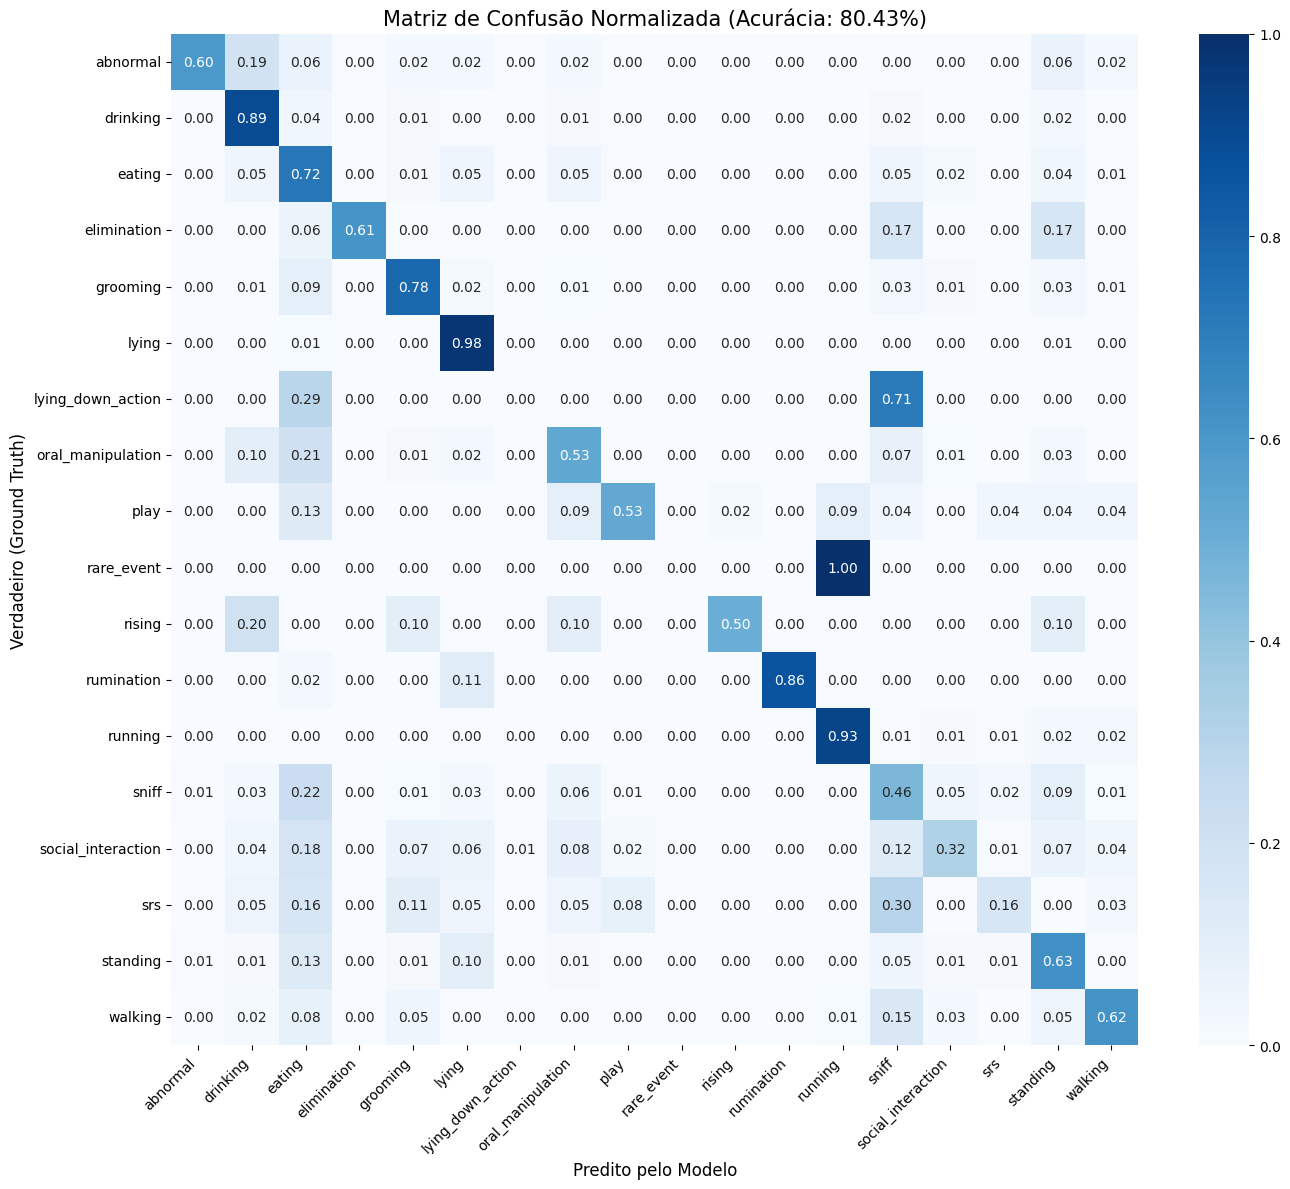

In [32]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import os

def evaluate_on_test(test_dl, num_classes, n_feats, device, checkpoint_path="best_hybrid_finetuned.pth", class_names=None):
    print(f"\nINICIANDO AVALIAÇÃO FINAL NO DATASET DE TESTE")
    print(f"   Modelo alvo: {checkpoint_path}")
    
    # 1nstancia o Modelo 
    model = RobustHybridModel(num_classes, n_feats).to(device)
    if os.path.exists(checkpoint_path):
        try:
            state_dict = torch.load(checkpoint_path, map_location=device)
            model.load_state_dict(state_dict)
        except Exception as e:
            print(f"Erro ao carregar pesos: {e}")
            return
    else:
        fallback = "best_hybrid_model.pth"
        if os.path.exists(fallback):
            print(f"'{checkpoint_path}' não encontrado. Usando '{fallback}'...")
            model.load_state_dict(torch.load(fallback, map_location=device))
        else:
            print("Nenhum checkpoint encontrado!")
            return

    # Loop de Predição
    model.eval() 
    
    criterion = nn.CrossEntropyLoss()
    test_loss = 0.0
    
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for x_sig, x_feat, y in test_dl:
            x_sig, x_feat, y = x_sig.to(device), x_feat.to(device), y.to(device)
            
            # Forward
            outputs = model(x_sig, x_feat)
            loss = criterion(outputs, y)
            
            test_loss += loss.item() * x_sig.size(0)
            
            # Pega a classe com maior probabilidade
            _, preds = torch.max(outputs, 1)
            
            # Guarda na CPU para usar no Scikit-Learn
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(y.cpu().numpy())
            
    # Médias
    avg_loss = test_loss / len(test_dl.dataset)
    acc = accuracy_score(all_labels, all_preds)
    
    print("\n" + "="*50)
    print(f"RESULTADO FINAL (TEST SET)")
    print("="*50)
    print(f"Acurácia Global: {acc:.2%}")
    print(f"Loss Média:      {avg_loss:.4f}")
    
    if class_names is None:
        class_names = [str(i) for i in range(num_classes)]
    print(classification_report(all_labels, all_preds, target_names=class_names, zero_division=0))
    
    # Matriz de Confusão
    cm = confusion_matrix(all_labels, all_preds)
    
    cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    cm_norm = np.nan_to_num(cm_norm)
    
    plt.figure(figsize=(14, 12))
    sns.heatmap(cm_norm, annot=True, fmt='.2f', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    
    plt.title(f'Matriz de Confusão Normalizada (Acurácia: {acc:.2%})', fontsize=15)
    plt.xlabel('Predito pelo Modelo', fontsize=12)
    plt.ylabel('Verdadeiro (Ground Truth)', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

evaluate_on_test(dl_test, 
                 num_classes=len(classes), 
                 n_feats=n_feats, 
                 device=device, 
                 checkpoint_path="best_hybrid_finetuned.pth",
                 class_names=classes)